In [ ]:
import os
import pandas as pd
import numpy as np

# 1. Imports per TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

# ---------------------------
# 1. Lees i preprocesses dades
# ---------------------------

# Ruta al CSV (ajusta-la segons el teu entorn)
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

# 1.1. Llegim el CSV
df = pd.read_csv(file_path)

# 1.2. Convertim 'Date' a datetime i ordenem cronològicament
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)

# 1.3. Definim quines columnes són les característiques (features) i la target
features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
target = 'Close'

# 1.4. Eliminem files amb NaNs a qualsevol feature o a la target
before_drop = len(df)
df.dropna(subset=features + [target], inplace=True)
after_drop = len(df)
print(f"Files originals: {before_drop}, files després de dropna: {after_drop} (s'han eliminat {before_drop - after_drop} files).")

# 1.5. Reinicialitzem l'índex per evitar forats
df.reset_index(drop=True, inplace=True)

# 1.6. Comprovació de NaNs
print("\nComprovació NaNs per columna:")
print(df[features + [target]].isna().sum())

# -----------------------------------
# 2. Split cronològic: train/val/test
# -----------------------------------

n_total = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)
test_size  = n_total - train_size - val_size

# 2.1. Extraiem X_raw i y_raw ja ordenats
X_raw = df[features].values
y_raw = df[target].values

# 2.2. Dividim en subconjunts (cronològic)
X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]

# 2.3. Verifiquem els rangs de dates de cada subconjunt
dates = df['Date']
date_train_start = dates.iloc[0]
date_train_end   = dates.iloc[train_size - 1]

date_val_start = dates.iloc[train_size]
date_val_end   = dates.iloc[train_size + val_size - 1]

date_test_start = dates.iloc[train_size + val_size]
date_test_end   = dates.iloc[-1]

print(f"\nRangs de dates:")
print(f"  Train: {date_train_start.date()} → {date_train_end.date()} ({len(X_train_raw)} samples)")
print(f"  Val:   {date_val_start.date()} → {date_val_end.date()} ({len(X_val_raw)} samples)")
print(f"  Test:  {date_test_start.date()} → {date_test_end.date()} ({len(X_test_raw)} samples)")

# 2.4. Assercions per assegurar-nos que no hi ha NaNs després del split
assert not np.isnan(X_train_raw).any(), "Hi ha NaNs a X_train_raw!"
assert not np.isnan(y_train_raw).any(), "Hi ha NaNs a y_train_raw!"
assert not np.isnan(X_val_raw).any(),   "Hi ha NaNs a X_val_raw!"
assert not np.isnan(y_val_raw).any(),   "Hi ha NaNs a y_val_raw!"
assert not np.isnan(X_test_raw).any(),  "Hi ha NaNs a X_test_raw!"
assert not np.isnan(y_test_raw).any(),  "Hi ha NaNs a y_test_raw!"
print("\nCap NaN trobat als subconjunts de train/val/test després del dropna.")

# ----------------------------------------------------
# 3. Escalat de característiques i de la target (Close)
# ----------------------------------------------------

# 3.1. Escalem X amb StandardScaler (només sobre X_train_raw)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

# Comprovem que l'escala no produeix NaNs ni Inf
assert not np.isnan(X_train).any() and not np.isinf(X_train).any(), "NaN/Inf a X_train escalat!"
assert not np.isnan(X_val).any()   and not np.isinf(X_val).any(),   "NaN/Inf a X_val escalat!"
assert not np.isnan(X_test).any()  and not np.isinf(X_test).any(),  "NaN/Inf a X_test escalat!"

# 3.2. Escalem y amb StandardScaler (només sobre y_train_raw)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_val   = scaler_y.transform(y_val_raw.reshape(-1, 1)).ravel()
y_test  = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

# Comprovem que no es generen NaNs ni Inf en y escalat
assert not np.isnan(y_train).any() and not np.isinf(y_train).any(), "NaN/Inf a y_train escalat!"
assert not np.isnan(y_val).any()   and not np.isinf(y_val).any(),   "NaN/Inf a y_val escalat!"
assert not np.isnan(y_test).any()  and not np.isinf(y_test).any(),  "NaN/Inf a y_test escalat!"

print("\nEscalat completat sense problemes de NaNs o Inf.")

# ----------------------------------------------------
# 4. Creem seqüències temporals per al model GRU
# ----------------------------------------------------

# Cal definir una finestra (look_back) per fer seqüències. Per exemple, 10 períodes anteriors
look_back = 10

def crear_sequencies(X, y, look_back):
    """
    Retorna X_seq, y_seq on X_seq és un array de forma (n_samples, look_back, n_features)
    i y_seq és un array de forma (n_samples,) amb el valor de target corresponent al final.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:(i + look_back), :])
        y_seq.append(y[i + look_back])
    return np.array(X_seq), np.array(y_seq)

# 4.1. Seqüències per a train
X_train_seq, y_train_seq = crear_sequencies(X_train, y_train, look_back)
# 4.2. Seqüències per a val
X_val_seq, y_val_seq     = crear_sequencies(X_val, y_val, look_back)
# 4.3. Seqüències per a test
X_test_seq, y_test_seq   = crear_sequencies(X_test, y_test, look_back)

print(f"\nShape de X_train_seq: {X_train_seq.shape} → (samples, timesteps={look_back}, features)")
print(f"Shape de y_train_seq: {y_train_seq.shape}")
print(f"Shape de X_val_seq:   {X_val_seq.shape}")
print(f"Shape de X_test_seq:  {X_test_seq.shape}")

# --------------------------------------
# 5. Construcció i compilació del model GRU
# --------------------------------------

n_features = X_train_seq.shape[2]  # nombre de features originals
units_gru = 64                     # nombre d'unitats a la capa GRU (es pot ajustar)

model = Sequential([
    # Capa GRU (pots provar diferents nombres d'unitats, i afegir Dropout si cal)
    GRU(units_gru, input_shape=(look_back, n_features), return_sequences=False),
    Dropout(0.2),
    # Capa denses finals per fer regressió (1 únic valor de sortida)
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

# ---------------------------
# 6. Entrenament del model
# ---------------------------

# Definim callbacks (early stopping sobre validation loss)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, 
    y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------------------------------
# 7. Avaluació sobre validation i test (metrics en escala original)
# -----------------------------------------------------

# 7.1. Prediccions (escalat) i després inverse transform per tenir preus reals
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
# La y_val_seq està escalada, però si volem comparar en escala original:
#   involem la transformació per a y_val_seq també
y_val_true = scaler_y.inverse_transform(y_val_seq.reshape(-1,1)).ravel()

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)

print(f"\nVALIDATION → GRU: RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# 7.2. Avaluació sobre TEST
y_test_pred_scaled = model.predict(X_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_test_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)

print(f"TEST       → GRU: RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# ---------------------------------------------------
# 8. Plot actual vs. predicted al TEST set (últims períodes)
# ---------------------------------------------------

# Com que hem perdut els primers 'look_back' dies en seqüències, cal ajustar els índexs de dates
dates_test = df['Date'].iloc[
    (train_size + val_size) + look_back : train_size + val_size + len(y_test_true) + look_back
].values

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_true, label='Actual Close', linestyle='-', marker='o', alpha=0.7)
plt.plot(dates_test, y_test_pred, label='Predicted Close (GRU)', linestyle='--', marker='x', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('GRU – Actual vs. Predicted (TEST)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------
# 9. (Opcional) Visualització de l'historial d'entrenament
# -------------------------------------

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Època')
plt.ylabel('Loss (RMSE escalat)')
plt.title('Historial d’entrenament: pèrdua (RMSE)')
plt.legend()
plt.tight_layout()
plt.show()


Files originals: 1278, files després de dropna: 1278 (s'han eliminat 0 files).

Comprovació NaNs per columna:
Open           0
High           0
Low            0
Volume         0
EMA_7          0
EMA_40         0
MACD           0
Signal_Line    0
MACD_Hist      0
RSI            0
ATR            0
Close          0
dtype: int64

Rangs de dates:
  Train: 2020-01-02 → 2023-07-21 (894 samples)
  Val:   2023-07-24 → 2024-04-24 (191 samples)
  Test:  2024-04-25 → 2025-01-31 (193 samples)

Cap NaN trobat als subconjunts de train/val/test després del dropna.

Escalat completat sense problemes de NaNs o Inf.

Shape de X_train_seq: (884, 10, 11) → (samples, timesteps=10, features)
Shape de y_train_seq: (884,)
Shape de X_val_seq:   (181, 10, 11)
Shape de X_test_seq:  (183, 10, 11)


c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


KeyboardInterrupt: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 128)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,009 (168.00 KB)

 Trainable params: 43,009 (168.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5043 - mae: 0.5626 - val_loss: 0.0974 - val_mae: 0.2342 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1529 - mae: 0.2962 - val_loss: 0.0497 - val_mae: 0.1463 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1360 - mae: 0.2726 - val_loss: 0.0619 - val_mae: 0.1760 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1212 - mae: 0.2578 - val_loss: 0.0456 - val_mae: 0.1416 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1130 - mae: 0.2488 - val_loss: 0.0496 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1090 - mae: 0.2378 - val_loss: 0.0433 - val_mae: 0.1391 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1060 - mae: 0.2358 - val_loss: 0.0490 - val_mae: 0.1552 - learning_rate: 0.0010
Epoch 8/100

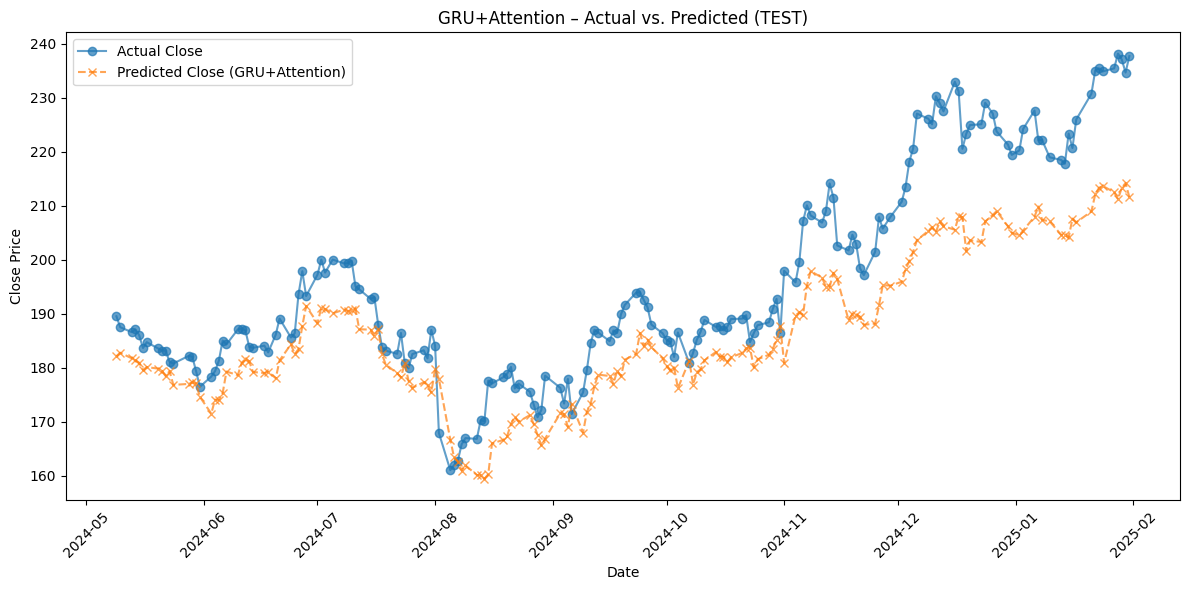

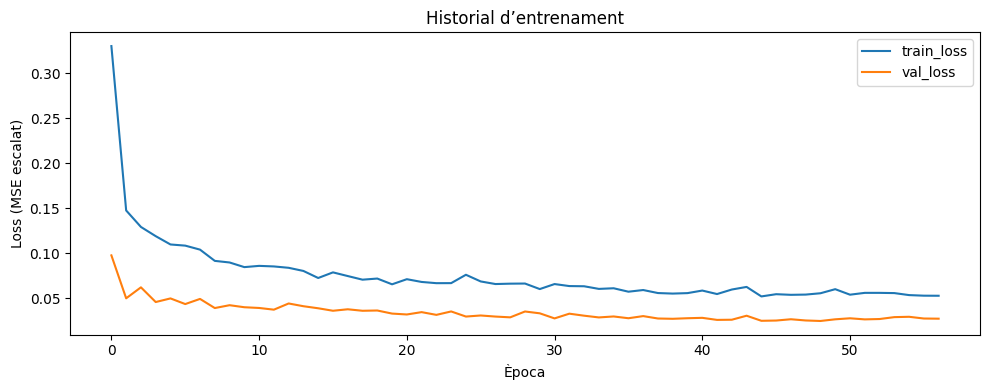

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------------------
# 1. Carrega i preprocessament de dades
# ------------------------------------------

BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)


# 1.3. Llista final de features
features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
] 

target = 'Close'

# 1.4. Elimina files amb NaNs
df.dropna(subset=features + [target], inplace=True)
df.reset_index(drop=True, inplace=True)

# ------------------------------------------
# 2. Divisió cronològica: train/val/test
# ------------------------------------------

n_total = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)

X_raw = df[features].values
y_raw = df[target].values

X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]

# ------------------------------------------
# 3. Escalat de característiques i target
# ------------------------------------------

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1,1)).ravel()
y_val   = scaler_y.transform(y_val_raw.reshape(-1,1)).ravel()
y_test  = scaler_y.transform(y_test_raw.reshape(-1,1)).ravel()

# ------------------------------------------
# 4. Creació de seqüències temporals
# ------------------------------------------

look_back = 10  # finestra de 20 dies

def crear_sequencies(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:(i + look_back), :])
        y_seq.append(y[i + look_back])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = crear_sequencies(X_train, y_train, look_back)
X_val_seq, y_val_seq     = crear_sequencies(X_val, y_val, look_back)
X_test_seq, y_test_seq   = crear_sequencies(X_test, y_test, look_back)

# ------------------------------------------
# 5. Definició de la capa d’atenció simple
# ------------------------------------------

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="attn_W",
                                 shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        score = tf.matmul(tf.tanh(inputs), self.W)  # (batch, timesteps, 1)
        weights = tf.nn.softmax(score, axis=1)       # (batch, timesteps, 1)
        context = tf.reduce_sum(weights * inputs, axis=1)  # (batch, features)
        return context

# ------------------------------------------
# 6. Construcció i compilació del model
# ------------------------------------------

n_features = X_train_seq.shape[2]

model = Sequential([
    Input(shape=(look_back, n_features)),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Bidirectional(GRU(64, return_sequences=True,
                      recurrent_dropout=0.2,
                      kernel_regularizer=regularizers.l2(1e-4))),
    Attention(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# ------------------------------------------
# 7. Callbacks: EarlyStopping i ReduceLROnPlateau
# ------------------------------------------

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6
)

# ------------------------------------------
# 8. Entrenament del model
# ------------------------------------------

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ------------------------------------------
# 9. Avaluació sobre validation i test
# ------------------------------------------

# Prediccions a Validation
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
y_val_true = scaler_y.inverse_transform(y_val_seq.reshape(-1,1)).ravel()

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)
print(f"\nVALIDATION → GRU+Attention: RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# Prediccions a Test
y_test_pred_scaled = model.predict(X_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_test_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)
print(f"TEST       → GRU+Attention: RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# ------------------------------------------
# 10. Visualització de resultats
# ------------------------------------------

# Ajust d’índexs de dates per al test (descartar els primers look_back dies)
dates_test = df['Date'].iloc[
    (train_size + val_size) + look_back : train_size + val_size + len(y_test_true) + look_back
].values

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_true, label='Actual Close', linestyle='-', marker='o', alpha=0.7)
plt.plot(dates_test, y_test_pred, label='Predicted Close (GRU+Attention)', linestyle='--', marker='x', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('GRU+Attention – Actual vs. Predicted (TEST)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Època')
plt.ylabel('Loss (MSE escalat)')
plt.title('Historial d’entrenament')
plt.legend()
plt.tight_layout()
plt.show()


Reloading Tuner from hyperparam_tuning\gru_attention_tuning\tuner0.json
Search space summary
Default search space size: 7
conv_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
gru_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
l2_reg (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001], 'ordered': True}
dense_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
Results summary
Results in hyperparam_tuning\gru_attention_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0381 - mae: 0.1440 - val_loss: 0.0137 - val_mae: 0.0813
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0335 - mae: 0.1329 - val_loss: 0.0197 - val_mae: 0.1047
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0267 - mae: 0.1182 - val_loss: 0.0184 - val_mae: 0.0970
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0279 - mae: 0.1232 - val_loss: 0.0179 - val_mae: 0.0958
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0294 - mae: 0.1214 - val_loss: 0.0291 - val_mae: 0.1292
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0343 - mae: 0.1354 - val_loss: 0.0164 - val_mae: 0.0926
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0278 - mae: 0.1220 - val_loss: 0.0172 - val_mae: 0.0961
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0256 - mae: 0.1185 - val_loss: 0.0180 - val_mae: 0.0989
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0310 -

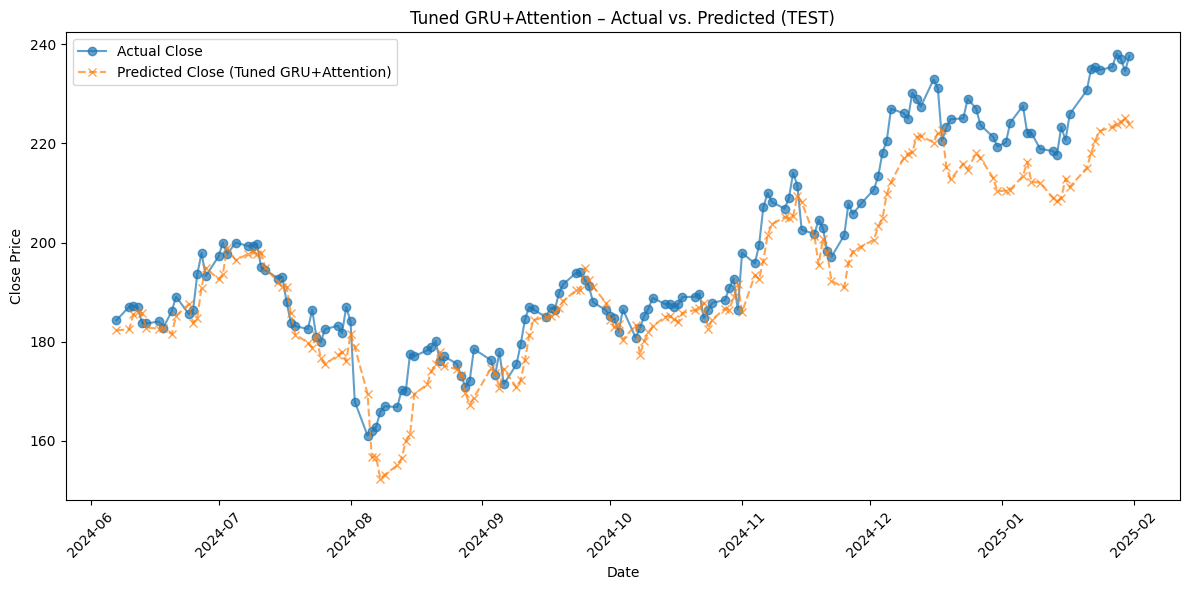

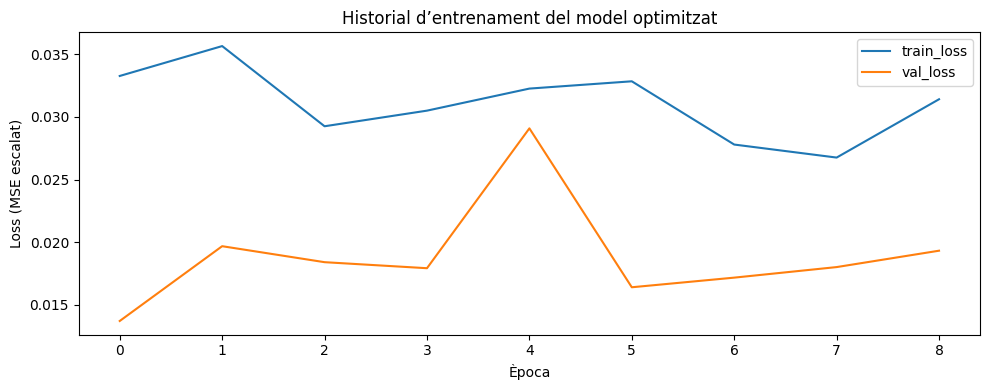

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools
import random

# Per a KerasTuner:
import keras_tuner as kt

# ------------------------------------------
# 1. Carrega i preprocessament de dades
# ------------------------------------------

BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# 1.1. Llista de features original (sense feature engineering)
features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
target = 'Close'

# 1.2. Elimina files amb NaNs a features o target
df.dropna(subset=features + [target], inplace=True)
df.reset_index(drop=True, inplace=True)

# ------------------------------------------
# 2. Divisió cronològica: train/val/test
# ------------------------------------------

n_total = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)

X_raw = df[features].values
y_raw = df[target].values

X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size:train_size + val_size]
y_val_raw   = y_raw[train_size:train_size + val_size]

X_test_raw  = X_raw[train_size + val_size:]
y_test_raw  = y_raw[train_size + val_size:]

# ------------------------------------------
# 3. Escalat de característiques i target
# ------------------------------------------

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1,1)).ravel()
y_val   = scaler_y.transform(y_val_raw.reshape(-1,1)).ravel()
y_test  = scaler_y.transform(y_test_raw.reshape(-1,1)).ravel()

# ------------------------------------------
# 4. Creació de seqüències temporals
# ------------------------------------------

look_back = 30  # finestra de 20 dies

def crear_sequencies(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:(i + look_back), :])
        y_seq.append(y[i + look_back])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = crear_sequencies(X_train, y_train, look_back)
X_val_seq, y_val_seq     = crear_sequencies(X_val, y_val, look_back)
X_test_seq, y_test_seq   = crear_sequencies(X_test, y_test, look_back)

# ------------------------------------------
# 5. Definició de la capa d’atenció simple
# ------------------------------------------

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="attn_W",
                                 shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        score = tf.matmul(tf.tanh(inputs), self.W)  # (batch, timesteps, 1)
        weights = tf.nn.softmax(score, axis=1)       # (batch, timesteps, 1)
        context = tf.reduce_sum(weights * inputs, axis=1)  # (batch, features)
        return context

# ------------------------------------------
# 6. Constructor de models per a KerasTuner
# ------------------------------------------

def build_model(hp):
    """
    Crea un model GRU+Attention amb hiperparàmetres definits per KerasTuner.
    """
    n_features = X_train_seq.shape[2]
    model = Sequential()
    model.add(Input(shape=(look_back, n_features)))

    # Conv1D + MaxPooling1D
    conv_filters = hp.Choice('conv_filters', [16, 32, 64])
    kernel_size  = hp.Choice('kernel_size', [3, 5])
    model.add(Conv1D(filters=conv_filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    # Capes bidireccionals de GRU
    gru_units = hp.Choice('gru_units', [32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.4, step=0.1)
    reg_factor = hp.Choice('l2_reg', [1e-4, 1e-3])

    # Amb return_sequences=True per alimentar atenció
    model.add(Bidirectional(
        GRU(units=gru_units,
            return_sequences=True,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=regularizers.l2(reg_factor)
        )
    ))

    # Capa d’atenció
    model.add(Attention())
    model.add(Dropout(dropout_rate))

    # Capa densa intermèdia
    dense_units = hp.Choice('dense_units', [16, 32, 64])
    model.add(Dense(dense_units,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(reg_factor)))
    model.add(Dropout(dropout_rate))

    # Capa de sortida
    model.add(Dense(1, activation='linear'))

    # Optimitzador amb learning rate variable
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

# ------------------------------------------
# 7. Executa la cerca d’hiperparàmetres
# ------------------------------------------

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,                 # prova fins a 20 combinacions diferents
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_attention_tuning'
)

# Mostrem el resum dels paràmetres que s'exploraran
tuner.search_space_summary()

# Callbacks per a l'entrenament durant la cerca
early_stop_tuner = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Iniciem la cerca
tuner.search(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop_tuner],
    verbose=1
)

# Mostrem els millors hiperparàmetres trobats
tuner.results_summary()

# Recuperem el millor model
best_model = tuner.get_best_models(num_models=1)[0]

# ------------------------------------------
# 8. Entrenament del millor model (fine-tuning)
# ------------------------------------------

# Opcionalment, podem continuar entrenant el best_model amb més èpoques
fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[fine_tune_stop],
    verbose=1
)

# ------------------------------------------
# 9. Avaluació sobre validation i test
# ------------------------------------------

# Prediccions a Validation
y_val_pred_scaled = best_model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
y_val_true = scaler_y.inverse_transform(y_val_seq.reshape(-1,1)).ravel()

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)
print(f"\nVALIDATION → Tuned GRU+Attention: MSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# Prediccions a Test
y_test_pred_scaled = best_model.predict(X_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_test_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)
print(f"TEST       → Tuned GRU+Attention: MSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# ------------------------------------------
# 10. Visualització de resultats
# ------------------------------------------

# Ajust d’índexs de dates per al test (descartar els primers look_back dies)
dates_test = df['Date'].iloc[
    (train_size + val_size) + look_back : train_size + val_size + len(y_test_true) + look_back
].values

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_true, label='Actual Close', linestyle='-', marker='o', alpha=0.7)
plt.plot(dates_test, y_test_pred, label='Predicted Close (Tuned GRU+Attention)', linestyle='--', marker='x', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tuned GRU+Attention – Actual vs. Predicted (TEST)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Època')
plt.ylabel('Loss (MSE escalat)')
plt.title('Historial d’entrenament del model optimitzat')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pip install -U keras-tuner


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\jesus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Reloading Tuner from hyperparam_tuning\gru_attention_tuning\tuner0.json
Search space summary
Default search space size: 7
conv_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
gru_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
l2_reg (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001], 'ordered': True}
dense_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
Results summary
Results in hyperparam_tuning\gru_attention_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0575 - mae: 0.1813 - val_loss: 0.0232 - val_mae: 0.1168
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - mae: 0.1174 - val_loss: 0.0212 - val_mae: 0.1062
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0291 - mae: 0.1237 - val_loss: 0.0214 - val_mae: 0.1064
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0306 - mae: 0.1288 - val_loss: 0.0182 - val_mae: 0.0984
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - mae: 0.1282 - val_loss: 0.0197 - val_mae: 0.1046
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0288 - mae: 0.1219 - val_loss: 0.0166 - val_mae: 0.0921
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0299 - mae: 0.1270 - val_loss: 0.0161 - val_mae: 0.0915
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - mae: 0.1270 - val_loss: 0.0152 - val_mae: 0.0869
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0274 -

TEST       → Tuned GRU+Attention: MSE: 133.8510, MAE: 8.8157, R²: 0.6437

Carpeta de resultats creada a: resultats_GRU_Attention\amazon_gru
  ✓ Hiperparàmetres guardats a: resultats_GRU_Attention\amazon_gru\best_hyperparameters.json
  ✓ Model complet guardat a: resultats_GRU_Attention\amazon_gru\best_model_saved.weights.h5
  ✓ Mètriques guardades a: resultats_GRU_Attention\amazon_gru\metrics_summary.csv


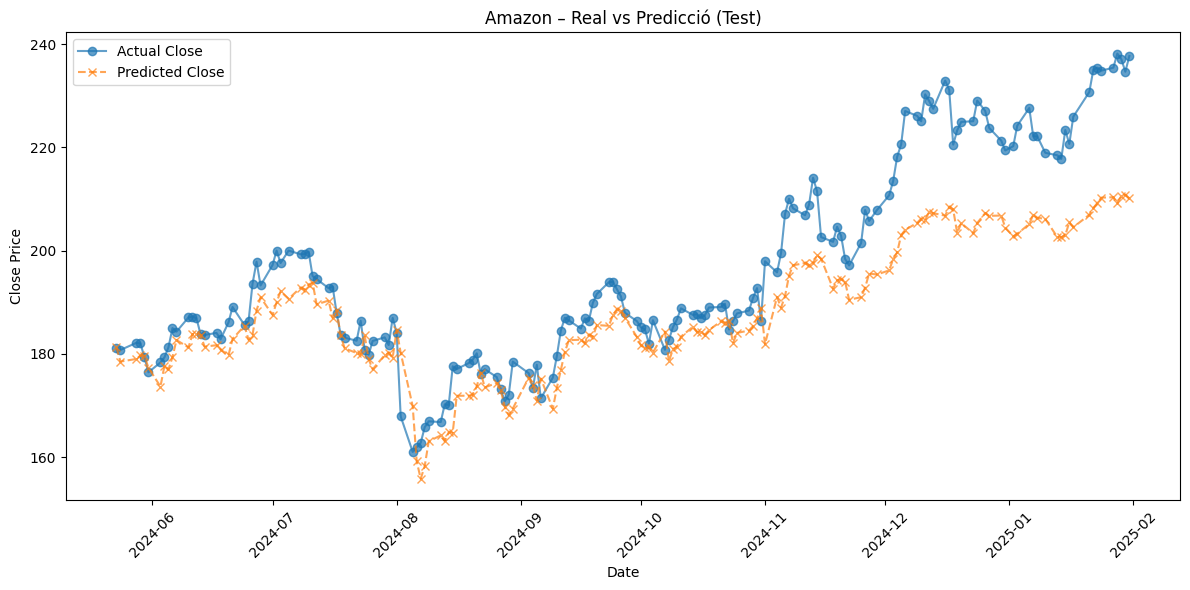

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools
import random

# Per a KerasTuner:
import keras_tuner as kt

# ------------------------------------------
# 1. Carrega i preprocessament de dades
# ------------------------------------------

BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Amazon_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# 1.1. Llista de features original (sense feature engineering)
features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
target = 'Close'

# 1.2. Elimina files amb NaNs a features o target
df.dropna(subset=features + [target], inplace=True)
df.reset_index(drop=True, inplace=True)

# ------------------------------------------
# 2. Divisió cronològica: train/val/test
# ------------------------------------------

n_total    = len(df)
train_size = int(n_total * 0.70)
val_size   = int(n_total * 0.15)

X_raw = df[features].values
y_raw = df[target].values

X_train_raw = X_raw[:train_size]
y_train_raw = y_raw[:train_size]

X_val_raw   = X_raw[train_size : train_size + val_size]
y_val_raw   = y_raw[train_size : train_size + val_size]

X_test_raw  = X_raw[train_size + val_size :]
y_test_raw  = y_raw[train_size + val_size :]

# ------------------------------------------
# 3. Escalat de característiques i target
# ------------------------------------------

scaler_X = StandardScaler()
X_train  = scaler_X.fit_transform(X_train_raw)
X_val    = scaler_X.transform(X_val_raw)
X_test   = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train  = scaler_y.fit_transform(y_train_raw.reshape(-1,1)).ravel()
y_val    = scaler_y.transform(y_val_raw.reshape(-1,1)).ravel()
y_test   = scaler_y.transform(y_test_raw.reshape(-1,1)).ravel()

# ------------------------------------------
# 4. Creació de seqüències temporals
# ------------------------------------------

look_back = 20  # finestra de 20 dies

def crear_sequencies(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:(i + look_back), :])
        y_seq.append(y[i + look_back])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = crear_sequencies(X_train, y_train, look_back)
X_val_seq,   y_val_seq   = crear_sequencies(X_val, y_val, look_back)
X_test_seq,  y_test_seq  = crear_sequencies(X_test, y_test, look_back)

# ------------------------------------------
# 5. Definició de la capa d’atenció simple
# ------------------------------------------

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="attn_W",
                                 shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        score   = tf.matmul(tf.tanh(inputs), self.W)   # (batch, timesteps, 1)
        weights = tf.nn.softmax(score, axis=1)          # (batch, timesteps, 1)
        context = tf.reduce_sum(weights * inputs, axis=1)  # (batch, features)
        return context

# ------------------------------------------
# 6. Constructor de models per a KerasTuner
# ------------------------------------------

def build_model(hp):
    """
    Crea un model GRU+Attention amb hiperparàmetres definits per KerasTuner.
    """
    n_features = X_train_seq.shape[2]
    model = Sequential()
    model.add(Input(shape=(look_back, n_features)))

    # Conv1D + MaxPooling1D
    conv_filters = hp.Choice('conv_filters', [16, 32, 64])
    kernel_size  = hp.Choice('kernel_size', [3, 5])
    model.add(Conv1D(filters=conv_filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    # Capa Bidirectional GRU
    gru_units    = hp.Choice('gru_units', [32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.4, step=0.1)
    reg_factor   = hp.Choice('l2_reg', [1e-4, 1e-3])

    model.add(Bidirectional(
        GRU(units=gru_units,
            return_sequences=True,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=regularizers.l2(reg_factor)
        )
    ))

    # Capa d’atenció
    model.add(Attention())
    model.add(Dropout(dropout_rate))

    # Capa densa intermèdia
    dense_units = hp.Choice('dense_units', [16, 32, 64])
    model.add(Dense(dense_units,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(reg_factor)))
    model.add(Dropout(dropout_rate))

    # Capa de sortida
    model.add(Dense(1, activation='linear'))

    # Optimitzador amb learning rate variable
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer     = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

# ------------------------------------------
# 7. Executa la cerca d’hiperparàmetres
# ------------------------------------------

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,                 # prova fins a 20 combinacions
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_attention_tuning'
)

# Veure resum de l’espai de cerca
tuner.search_space_summary()

early_stop_tuner = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop_tuner],
    verbose=1
)

tuner.results_summary()

# 7.1. Obtenim el millor hyperparameter object i el convertim a dict
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp_values = best_hp.values  # és un dict: {'conv_filters': 32, 'kernel_size': 3, ... }

# ------------------------------------------
# 8. Entrenament del millor model (fine‐tuning)
# ------------------------------------------

best_model = tuner.get_best_models(num_models=1)[0]

fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[fine_tune_stop],
    verbose=1
)

# ------------------------------------------
# 9. Avaluació sobre validation i test
# ------------------------------------------

# 9.1. Validation
y_val_pred_scaled = best_model.predict(X_val_seq)
y_val_pred        = scaler_y.inverse_transform(y_val_pred_scaled).ravel()
y_val_true        = scaler_y.inverse_transform(y_val_seq.reshape(-1,1)).ravel()

rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae_val = mean_absolute_error(y_val_true, y_val_pred)
r2_val  = r2_score(y_val_true, y_val_pred)
print(f"\nVALIDATION → Tuned GRU+Attention: MSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R²: {r2_val:.4f}")

# 9.2. Test
y_test_pred_scaled = best_model.predict(X_test_seq)
y_test_pred        = scaler_y.inverse_transform(y_test_pred_scaled).ravel()
y_test_true        = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test  = r2_score(y_test_true, y_test_pred)
print(f"TEST       → Tuned GRU+Attention: RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

# ------------------------------------------
# 10. Creació carpeta de resultats
# ------------------------------------------

results_base = "resultats_GRU_Attention"
model_folder = os.path.join(results_base, "amazon_gru")

os.makedirs(model_folder, exist_ok=True)
print(f"\nCarpeta de resultats creada a: {model_folder}")
dataset_name = 'amazon'

# ------------------------------------------
# 11. Guardar els millors hiperparàmetres en JSON
# ------------------------------------------

hp_json_path = os.path.join(model_folder, "best_hyperparameters.json")
with open(hp_json_path, "w") as f:
    json.dump(best_hp_values, f, indent=2)
print(f"  ✓ Hiperparàmetres guardats a: {hp_json_path}")

# ------------------------------------------
# 12. Guardar el model complet (SavedModel)
# ------------------------------------------

# D’aquesta manera guardem arquitectura + pesos
saved_model_path = os.path.join(model_folder, "best_model_saved.weights.h5")
best_model.save(saved_model_path)
print(f"  ✓ Model complet guardat a: {saved_model_path}")

# També pots guardar només els pesos si vols:
# weights_path = os.path.join(model_folder, "best_model_weights.h5")
# best_model.save_weights(weights_path)
# print(f"  ✓ Pesos guardats a: {weights_path}")

# ------------------------------------------
# 13. Guardar mètriques en un CSV
# ------------------------------------------

metrics = pd.DataFrame({
    "Dataset": [dataset_name],
    "MAE":     [mae_test],
    "RMSE":    [rmse_test],
    "R2":      [r2_test]
})
metrics_csv = os.path.join(model_folder, "metrics_summary.csv")
metrics.to_csv(metrics_csv, index=False)
print(f"  ✓ Mètriques guardades a: {metrics_csv}")

# ------------------------------------------
# 14. Graficar Real vs Predicho (Test) amb matplotlib i guardar en PNG
# ------------------------------------------

dates_test = df['Date'].iloc[
    (train_size + val_size) + look_back : train_size + val_size + len(y_test_true) + look_back
].values

plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test_true, label='Actual Close', linestyle='-', marker='o', alpha=0.7)
plt.plot(dates_test, y_test_pred, label='Predicted Close', linestyle='--', marker='x', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{dataset_name.capitalize()} – Real vs Predicció (Test)')
plt.legend()
plt.tight_layout()

